In [1]:
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.utils import timeseries_dataset_from_array
from keras import Input, Model
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [2]:
print("Gpu disponível: ", tf.config.list_physical_devices('GPU'))

Gpu disponível:  []


In [3]:
print("Gpu disponível: ", tf.config.list_physical_devices('GPU'))

Gpu disponível:  []


In [4]:
import os

current_dir = os.getcwd()
path_file = os.path.join(current_dir, "datasets/jena_climate_2009_2016.csv")
df = pd.read_csv(path_file, header=0)

In [5]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420451 entries, 0 to 420450
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420451 non-null  object 
 1   p (mbar)         420451 non-null  float64
 2   T (degC)         420451 non-null  float64
 3   Tpot (K)         420451 non-null  float64
 4   Tdew (degC)      420451 non-null  float64
 5   rh (%)           420451 non-null  float64
 6   VPmax (mbar)     420451 non-null  float64
 7   VPact (mbar)     420451 non-null  float64
 8   VPdef (mbar)     420451 non-null  float64
 9   sh (g/kg)        420451 non-null  float64
 10  H2OC (mmol/mol)  420451 non-null  float64
 11  rho (g/m**3)     420451 non-null  float64
 12  wv (m/s)         420451 non-null  float64
 13  max. wv (m/s)    420451 non-null  float64
 14  wd (deg)         420451 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


In [7]:
df = df.loc[:, df.columns != 'Date Time']

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420451 entries, 0 to 420450
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   p (mbar)         420451 non-null  float64
 1   T (degC)         420451 non-null  float64
 2   Tpot (K)         420451 non-null  float64
 3   Tdew (degC)      420451 non-null  float64
 4   rh (%)           420451 non-null  float64
 5   VPmax (mbar)     420451 non-null  float64
 6   VPact (mbar)     420451 non-null  float64
 7   VPdef (mbar)     420451 non-null  float64
 8   sh (g/kg)        420451 non-null  float64
 9   H2OC (mmol/mol)  420451 non-null  float64
 10  rho (g/m**3)     420451 non-null  float64
 11  wv (m/s)         420451 non-null  float64
 12  max. wv (m/s)    420451 non-null  float64
 13  wd (deg)         420451 non-null  float64
dtypes: float64(14)
memory usage: 44.9 MB


In [9]:
X = df.loc[:, df.columns != 'T (degC)']
y = df.loc[:, 'T (degC)']

In [10]:
X.shape, y.shape

((420451, 13), (420451,))

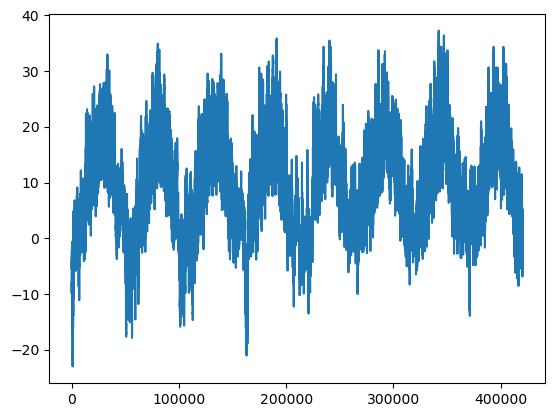

In [11]:
plt.plot(range(len(y)), y)

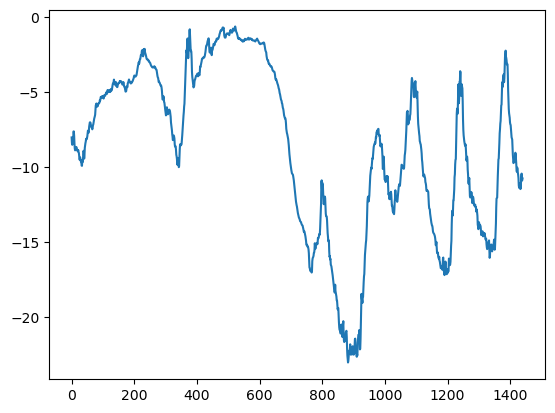

In [12]:
plt.plot(range(1440), y[:1440])

In [13]:
num_train_samples = int(0.5 * len(X))
num_val_samples = int(0.25 * len(X))
num_test_samples = len(X) - num_train_samples - num_val_samples

print('num_train_samples:', num_train_samples)
print('num_val_samples:', num_val_samples)
print('num_test_samples:', num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [14]:
mean = X[:num_train_samples].mean(axis=0)
X -= mean
std = X[:num_train_samples].std(axis=0)
X /= std

In [15]:
sampling_rate = 6
sequence_length = 12
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = timeseries_dataset_from_array(
    X[:-delay],
    targets = y[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length, 
    shuffle = True,
    batch_size = batch_size,
    start_index = 0,
    end_index = num_train_samples
)

val_dataset = timeseries_dataset_from_array(
    X[:-delay],
    targets = y[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples,
    end_index = num_train_samples + num_val_samples
)

test_dataset = timeseries_dataset_from_array(
    X[:-delay],
    targets = y[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples + num_val_samples
)

In [16]:
samples, targets = next(iter(train_dataset))
samples.shape 

TensorShape([256, 12, 13])

In [17]:
targets.shape

TensorShape([256])

In [18]:
inputs = Input(shape = (sequence_length, X.shape[-1]))
x = Dense(16, activation = 'relu')(inputs)
outputs = Dense(1)(x)
model = Model(inputs = inputs, outputs = outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 12, 13)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12, 16)         │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12, 1)          │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241 (964.00 B)

 Trainable params: 241 (964.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
callbacks = [
    ModelCheckpoint('jena_dense.keras', save_best_only = True)
]

model.compile(optimizer = 'rmsprop',
                        loss = 'mse',
                        metrics=['mae'])

In [22]:
with tf.device('/device:GPU:0'):
    history = model.fit(train_dataset,
                        epochs = 10,
                        validation_data = val_dataset,
                        callbacks = callbacks)

Epoch 1/10


821/821 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 107.0433 - mae: 8.3892 - val_loss: 66.4730 - val_mae: 6.6968
Epoch 2/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 76.8100 - mae: 7.0980 - val_loss: 65.5994 - val_mae: 6.6577
Epoch 3/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 76.5290 - mae: 7.0848 - val_loss: 65.6579 - val_mae: 6.6609
Epoch 4/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 76.4977 - mae: 7.0830 - val_loss: 65.4460 - val_mae: 6.6509
Epoch 5/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 76.5183 - mae: 7.0841 - val_loss: 65.5379 - val_mae: 6.6554
Epoch 6/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 76.5079 - mae: 7.0835 - val_loss: 65.6294 - val_mae: 6.6597
Epoch 7/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 76.4999 - mae: 7.0844 - val_loss: 65.5933 - val_mae: 6.6580
Epoch 8/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 76.4933 - mae: 7.0829 - val_loss: 65.5138 - val_mae: 6.6543
Epoch 9/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 9

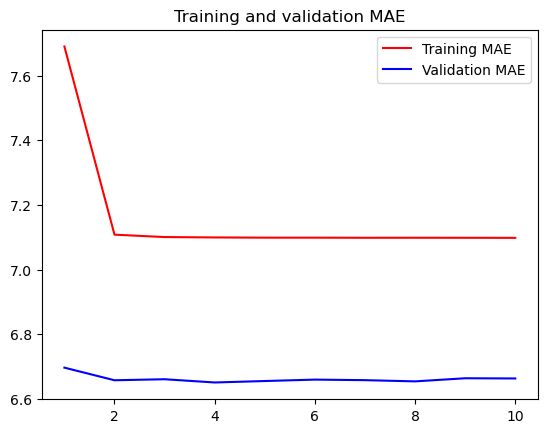

In [23]:
mae = history.history["mae"]
val_mae = history.history["val_mae"]
epochs = range(1, len(mae) + 1)
plt.figure()
plt.plot(epochs, mae, "r", label="Training MAE")
plt.plot(epochs, val_mae, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()